In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Ghost Batch Normalization Class

In [0]:

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        #print("batch norm")
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        #print("Ghost batch norm",num_features)
        super().__init__(num_features, **kw)
        #print("Ghost batch norm...1...",num_features)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)


## Defining a Network capabale of having Batch Normalization or Ghost Batch Normalization

In [0]:
dropout_value = 0
class Net(nn.Module):

    def __init__(self,batch_normalization=False,ghost_batch_normalization=False):
        super(Net, self).__init__()
        self.do_bn = batch_normalization        
        self.do_ghost_bn = ghost_batch_normalization 


        self.conv1 = nn.Sequential(nn.Conv2d(1, 8, 3, padding=0, bias=False),nn.ReLU(inplace=True),nn.Dropout(dropout_value)) # output_size = 26, RF = 3
        if self.do_bn:
          self.conv1_bn = nn.BatchNorm2d(8) 
        elif self.do_ghost_bn:          
          self.conv1_ghost_bn = GhostBatchNorm(8,2)
                

        self.conv2 = nn.Sequential(nn.Conv2d(8, 12, 3, padding=0, bias=False), nn.ReLU(inplace=True),nn.Dropout(dropout_value)) # output_size = 24, RF = 5
        if self.do_bn:
          self.conv2_bn = nn.BatchNorm2d(12) 
        elif self.do_ghost_bn:          
          self.conv2_ghost_bn = GhostBatchNorm(12,2)             


        self.conv3 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2),nn.Conv2d(12, 8, 1, padding=0, bias=False),nn.ReLU(inplace=True),nn.Dropout(dropout_value)) # output_size = 12, RF = 6
        if self.do_bn:   
          self.conv3_bn = nn.BatchNorm2d(8) 
        elif self.do_ghost_bn:          
          self.conv3_ghost_bn = GhostBatchNorm(8,2)              


        self.conv4 = nn.Sequential(nn.Conv2d(8, 12, 3, padding=0, bias=False),nn.ReLU(inplace=True), nn.Dropout(dropout_value)) # output_size = 10, RF = 10
        if self.do_bn: 
          self.conv4_bn = nn.BatchNorm2d(12)
        elif self.do_ghost_bn:          
          self.conv4_ghost_bn = GhostBatchNorm(12,2)             


        self.conv5 = nn.Sequential(nn.Conv2d(12, 16, 3, padding=0, bias=False),nn.ReLU(inplace=True),nn.Dropout(dropout_value)) # output_size = 8, RF = 14
        if self.do_bn:
          self.conv5_bn = nn.BatchNorm2d(16)
        elif self.do_ghost_bn:          
          self.conv5_ghost_bn = GhostBatchNorm(16,2)             


        self.conv6 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=0, bias=False),nn.ReLU(inplace=True),nn.Dropout(dropout_value)) # output_size = 6, RF = 18
        if self.do_bn:
          self.conv6_bn = nn.BatchNorm2d(32)
        elif self.do_ghost_bn:          
          self.conv6_ghost_bn = GhostBatchNorm(32,2)               


        self.gap = nn.AvgPool2d(kernel_size=6) # output_size = 1, RF = 28
        self.conv7 = nn.Sequential(nn.Conv2d(32, 10, 1, padding=0, bias=False)) # output_size = 1, RF = 28


    def forward(self, x):

        # Model with Batch Normalization
        if self.do_bn: 
          x = self.conv1(x)
          x = self.conv1_bn(x)          
          x = self.conv2(x)
          x = self.conv2_bn(x)   
          x = self.conv3(x)
          x = self.conv3_bn(x)   
          x = self.conv4(x)
          x = self.conv4_bn(x)
          x = self.conv5(x)
          x = self.conv5_bn(x)
          x = self.conv6(x)
          x = self.conv6_bn(x)

        # Model with Ghost Batch Normalization
        elif self.do_ghost_bn:

          x = self.conv1(x)
          x = self.conv1_ghost_bn(x)          
          x = self.conv2(x)
          x = self.conv2_ghost_bn(x)   
          x = self.conv3(x)
          x = self.conv3_ghost_bn(x)   
          x = self.conv4(x)
          x = self.conv4_ghost_bn(x)
          x = self.conv5(x)
          x = self.conv5_ghost_bn(x)
          x = self.conv6(x)
          x = self.conv6_ghost_bn(x)

        else:
          x = self.conv1(x)
          x = self.conv2(x)
          x = self.conv3(x)
          x = self.conv4(x)
          x = self.conv5(x)
          x = self.conv6(x)
            

        x = self.gap(x)
        x = self.conv7(x)
        x = x.view(-1, 10)

        return F.log_softmax(x)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net(batch_normalization=True,ghost_batch_normalization=False).to(device)
model2=Net(batch_normalization=False,ghost_batch_normalization=True).to(device)
summary(model, input_size=(1, 28, 28))
summary(model2, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
           Dropout-3            [-1, 8, 26, 26]               0
       BatchNorm2d-4            [-1, 8, 26, 26]              16
            Conv2d-5           [-1, 12, 24, 24]             864
              ReLU-6           [-1, 12, 24, 24]               0
           Dropout-7           [-1, 12, 24, 24]               0
       BatchNorm2d-8           [-1, 12, 24, 24]              24
         MaxPool2d-9           [-1, 12, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              96
             ReLU-11            [-1, 8, 12, 12]               0
          Dropout-12            [-1, 8, 12, 12]               0
      BatchNorm2d-13            [-1, 8, 12, 12]              16
           Conv2d-14           [-1, 12,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
torch.manual_seed(1)
batch_size = 128            #Used for Batch Normalization Model
gosht_BN_batch_size = 64    #Used for Ghost Batch Normalization Model

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


#For Ghost Batch Normalization - different batch size
ghost_BN_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=gosht_BN_batch_size, shuffle=True, **kwargs)


ghost_BN_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=gosht_BN_batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
def train_eval(model, device, train_loader):
    model.eval()
    train_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            train_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)

    print('\n\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
test_acc = []
train_acc = []
#final_test_results=[]

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    print("length of test dataset",len(test_loader.dataset))
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    #print("in Test...final losses",test_losses)
    #print("in Test...final accuracies",test_acc)
    final_test_results.append(test_losses)
    final_test_results.append(test_acc)
    
    return test_losses,test_acc

In [0]:
def l1_train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for parameter in model.parameters():
      reg_loss += l1_crit(parameter, loss)
    factor = 0.00025
    loss += factor * reg_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    


# Training the model for 8 different conditions

In [0]:
from torch.optim.lr_scheduler import StepLR

BN_model = Net(batch_normalization=True,ghost_batch_normalization=False).to(device)  #Batch Normalization Model
GBN_model=Net(batch_normalization=False,ghost_batch_normalization=True).to(device)   #Ghost Batch Normalization Model

# Training for 25 Epocs 
EPOCHS = 25
for i in range(9):
  test_losses = []
  test_acc = []
  final_test_results=[]

  for epoch in range(EPOCHS):
    if i == 0:
      print("CASE_1: without L1andL2 with BN")
      print("EPOCH:", epoch)
      optimizer = optim.SGD(BN_model.parameters(), lr=0.01, momentum=0.9)
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      train(BN_model, device, train_loader, optimizer, epoch)
      results1 = test(BN_model, device, test_loader)
      

    elif i == 1:
      print("CASE_1: without L1andL2 with GBN")
      print("EPOCH:", epoch)            
      optimizer = optim.SGD(GBN_model.parameters(), lr=0.01, momentum=0.9)
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      train(GBN_model, device, ghost_BN_train_loader, optimizer, epoch)
      results2 = test(GBN_model, device, ghost_BN_test_loader)
      
    elif i == 2:
      print("CASE_2: with L1 with BN")
      print("EPOCH:", epoch)   
      
      optimizer = optim.SGD(BN_model.parameters(), lr=0.01, momentum=0.9)
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      l1_train(BN_model, device, train_loader, optimizer, epoch)
      results3 = test(BN_model, device, test_loader)

    elif i == 3:
      print("CASE_3: with L1 with GBN")
      print("EPOCH:", epoch)    
       
      optimizer = optim.SGD(GBN_model.parameters(), lr=0.01, momentum=0.9)
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      l1_train(GBN_model, device, ghost_BN_train_loader, optimizer, epoch)
      results4 = test(GBN_model, device, ghost_BN_test_loader)


    elif i == 4:
      print("CASE_4: with L2 with BN")
      print("EPOCH:", epoch)   
      
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      optimizer = optim.SGD(BN_model.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
      train(BN_model, device, train_loader, optimizer, epoch)
      results5 =test(BN_model, device, test_loader)

    elif i == 5:
      print("CASE_5: with L2 with GBN")
      print("EPOCH:", epoch)    
      
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      optimizer = optim.SGD(GBN_model.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
      train(GBN_model, device, ghost_BN_train_loader, optimizer, epoch)
      results6 =test(GBN_model, device, ghost_BN_test_loader)


    elif i ==6:
      print("CASE_6: with L1andL2 with BN")
      print("EPOCH:", epoch)     
      
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      optimizer = optim.SGD(BN_model.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
      l1_train(BN_model, device, train_loader, optimizer, epoch)
      results7 =test(BN_model, device, test_loader)    


    elif i ==7:
      print("CASE_7: with L1andL2 with GBN")
      print("EPOCH:", epoch)  
        
      scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
      optimizer = optim.SGD(GBN_model.parameters(), lr=0.01, weight_decay=1e-5, momentum=0.9)
      l1_train(GBN_model, device, ghost_BN_train_loader, optimizer, epoch)
      results8 =test(GBN_model, device, ghost_BN_test_loader)    


  0%|          | 0/469 [00:00<?, ?it/s]

CASE_1: without L1andL2 with BN
EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.1115436926484108 Batch_id=468 Accuracy=90.05: 100%|██████████| 469/469 [00:13<00:00, 33.74it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0947, Accuracy: 9746/10000 (97.46%)

CASE_1: without L1andL2 with BN
EPOCH: 1


Loss=0.05358836054801941 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:13<00:00, 34.18it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0585, Accuracy: 9826/10000 (98.26%)

CASE_1: without L1andL2 with BN
EPOCH: 2


Loss=0.09482685476541519 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:14<00:00, 32.15it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9869/10000 (98.69%)

CASE_1: without L1andL2 with BN
EPOCH: 3


Loss=0.02034507691860199 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:15<00:00, 30.62it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9887/10000 (98.87%)

CASE_1: without L1andL2 with BN
EPOCH: 4


Loss=0.030622148886322975 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:14<00:00, 31.42it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9879/10000 (98.79%)

CASE_1: without L1andL2 with BN
EPOCH: 5


Loss=0.054179880768060684 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:15<00:00, 29.86it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9912/10000 (99.12%)

CASE_1: without L1andL2 with BN
EPOCH: 6


Loss=0.0979597195982933 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9901/10000 (99.01%)

CASE_1: without L1andL2 with BN
EPOCH: 7


Loss=0.007012104149907827 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:15<00:00, 29.38it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9918/10000 (99.18%)

CASE_1: without L1andL2 with BN
EPOCH: 8


Loss=0.01417987048625946 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 30.43it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9921/10000 (99.21%)

CASE_1: without L1andL2 with BN
EPOCH: 9


Loss=0.025974459946155548 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 30.77it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9909/10000 (99.09%)

CASE_1: without L1andL2 with BN
EPOCH: 10


Loss=0.01613856852054596 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:16<00:00, 29.11it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9924/10000 (99.24%)

CASE_1: without L1andL2 with BN
EPOCH: 11


Loss=0.010043268091976643 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 28.64it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9918/10000 (99.18%)

CASE_1: without L1andL2 with BN
EPOCH: 12


Loss=0.010414634831249714 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:16<00:00, 29.31it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9915/10000 (99.15%)

CASE_1: without L1andL2 with BN
EPOCH: 13


Loss=0.07252903282642365 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 32.24it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9912/10000 (99.12%)

CASE_1: without L1andL2 with BN
EPOCH: 14


Loss=0.043690960854291916 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 33.33it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9917/10000 (99.17%)

CASE_1: without L1andL2 with BN
EPOCH: 15


Loss=0.014593079686164856 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 32.94it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9933/10000 (99.33%)

CASE_1: without L1andL2 with BN
EPOCH: 16


Loss=0.05058695748448372 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 33.06it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9931/10000 (99.31%)

CASE_1: without L1andL2 with BN
EPOCH: 17


Loss=0.03514931723475456 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 32.66it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9925/10000 (99.25%)

CASE_1: without L1andL2 with BN
EPOCH: 18


Loss=0.012175500392913818 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9929/10000 (99.29%)

CASE_1: without L1andL2 with BN
EPOCH: 19


Loss=0.008294587023556232 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 32.44it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)

CASE_1: without L1andL2 with BN
EPOCH: 20


Loss=0.008345186710357666 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:14<00:00, 32.37it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9937/10000 (99.37%)

CASE_1: without L1andL2 with BN
EPOCH: 21


Loss=0.004875148180872202 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:14<00:00, 32.73it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9930/10000 (99.30%)

CASE_1: without L1andL2 with BN
EPOCH: 22


Loss=0.017065897583961487 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:14<00:00, 33.02it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9937/10000 (99.37%)

CASE_1: without L1andL2 with BN
EPOCH: 23


Loss=0.01935226283967495 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9926/10000 (99.26%)

CASE_1: without L1andL2 with BN
EPOCH: 24


Loss=0.004124606493860483 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:14<00:00, 32.77it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9941/10000 (99.41%)

CASE_1: without L1andL2 with GBN
EPOCH: 0


Loss=0.16591165959835052 Batch_id=937 Accuracy=91.55: 100%|██████████| 938/938 [00:18<00:00, 50.32it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0688, Accuracy: 9792/10000 (97.92%)

CASE_1: without L1andL2 with GBN
EPOCH: 1


Loss=0.008722960948944092 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:18<00:00, 50.94it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9845/10000 (98.45%)

CASE_1: without L1andL2 with GBN
EPOCH: 2


Loss=0.03186069428920746 Batch_id=937 Accuracy=98.12: 100%|██████████| 938/938 [00:18<00:00, 50.88it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9891/10000 (98.91%)

CASE_1: without L1andL2 with GBN
EPOCH: 3


Loss=0.020488306879997253 Batch_id=937 Accuracy=98.38: 100%|██████████| 938/938 [00:18<00:00, 49.86it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9899/10000 (98.99%)

CASE_1: without L1andL2 with GBN
EPOCH: 4


Loss=0.027464762330055237 Batch_id=937 Accuracy=98.47: 100%|██████████| 938/938 [00:18<00:00, 50.08it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9902/10000 (99.02%)

CASE_1: without L1andL2 with GBN
EPOCH: 5


Loss=0.0864030122756958 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:18<00:00, 50.62it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9912/10000 (99.12%)

CASE_1: without L1andL2 with GBN
EPOCH: 6


Loss=0.012508854269981384 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:18<00:00, 50.54it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9921/10000 (99.21%)

CASE_1: without L1andL2 with GBN
EPOCH: 7


Loss=0.051166512072086334 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [00:18<00:00, 50.43it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9921/10000 (99.21%)

CASE_1: without L1andL2 with GBN
EPOCH: 8


Loss=0.03003944456577301 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:18<00:00, 49.72it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9918/10000 (99.18%)

CASE_1: without L1andL2 with GBN
EPOCH: 9


Loss=0.000858694314956665 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:18<00:00, 49.58it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

CASE_1: without L1andL2 with GBN
EPOCH: 10


Loss=0.04850207269191742 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:18<00:00, 49.97it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9918/10000 (99.18%)

CASE_1: without L1andL2 with GBN
EPOCH: 11


Loss=0.0066704899072647095 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:19<00:00, 49.22it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9931/10000 (99.31%)

CASE_1: without L1andL2 with GBN
EPOCH: 12


Loss=0.16566497087478638 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:19<00:00, 47.39it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9935/10000 (99.35%)

CASE_1: without L1andL2 with GBN
EPOCH: 13


Loss=0.06761787831783295 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:19<00:00, 48.21it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9923/10000 (99.23%)

CASE_1: without L1andL2 with GBN
EPOCH: 14


Loss=0.08553758263587952 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:19<00:00, 47.63it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9925/10000 (99.25%)

CASE_1: without L1andL2 with GBN
EPOCH: 15


Loss=0.013822659850120544 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:18<00:00, 49.91it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9920/10000 (99.20%)

CASE_1: without L1andL2 with GBN
EPOCH: 16


Loss=0.005670681595802307 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:17<00:00, 52.40it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9931/10000 (99.31%)

CASE_1: without L1andL2 with GBN
EPOCH: 17


Loss=0.35050326585769653 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:18<00:00, 51.43it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9923/10000 (99.23%)

CASE_1: without L1andL2 with GBN
EPOCH: 18


Loss=0.03730473667383194 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:18<00:00, 51.06it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9937/10000 (99.37%)

CASE_1: without L1andL2 with GBN
EPOCH: 19


Loss=0.034762799739837646 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:18<00:00, 51.10it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

CASE_1: without L1andL2 with GBN
EPOCH: 20


Loss=0.05753782391548157 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:18<00:00, 51.35it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9929/10000 (99.29%)

CASE_1: without L1andL2 with GBN
EPOCH: 21


Loss=0.06307625770568848 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:18<00:00, 51.01it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9935/10000 (99.35%)

CASE_1: without L1andL2 with GBN
EPOCH: 22


Loss=0.006143897771835327 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:18<00:00, 51.66it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9923/10000 (99.23%)

CASE_1: without L1andL2 with GBN
EPOCH: 23


Loss=0.030738860368728638 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:18<00:00, 49.97it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99.34%)

CASE_1: without L1andL2 with GBN
EPOCH: 24


Loss=0.08137565851211548 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:18<00:00, 50.79it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9934/10000 (99.34%)

CASE_2: with L1 with BN
EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([8, 1, 3, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([])) 

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9905/10000 (99.05%)

CASE_2: with L1 with BN
EPOCH: 1


Loss=0.20114970207214355 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9899/10000 (98.99%)

CASE_2: with L1 with BN
EPOCH: 2


Loss=0.18120330572128296 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 29.22it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9922/10000 (99.22%)

CASE_2: with L1 with BN
EPOCH: 3


Loss=0.18985053896903992 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9915/10000 (99.15%)

CASE_2: with L1 with BN
EPOCH: 4


Loss=0.18529818952083588 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 29.33it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9906/10000 (99.06%)

CASE_2: with L1 with BN
EPOCH: 5


Loss=0.18144719302654266 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:16<00:00, 29.08it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9905/10000 (99.05%)

CASE_2: with L1 with BN
EPOCH: 6


Loss=0.24998676776885986 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9915/10000 (99.15%)

CASE_2: with L1 with BN
EPOCH: 7


Loss=0.16831548511981964 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9891/10000 (98.91%)

CASE_2: with L1 with BN
EPOCH: 8


Loss=0.19312520325183868 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9864/10000 (98.64%)

CASE_2: with L1 with BN
EPOCH: 9


Loss=0.1973637491464615 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:16<00:00, 28.71it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9915/10000 (99.15%)

CASE_2: with L1 with BN
EPOCH: 10


Loss=0.32557547092437744 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9905/10000 (99.05%)

CASE_2: with L1 with BN
EPOCH: 11


Loss=0.2574605941772461 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:16<00:00, 28.82it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9905/10000 (99.05%)

CASE_2: with L1 with BN
EPOCH: 12


Loss=0.16693057119846344 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9915/10000 (99.15%)

CASE_2: with L1 with BN
EPOCH: 13


Loss=0.16023118793964386 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:16<00:00, 28.22it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9913/10000 (99.13%)

CASE_2: with L1 with BN
EPOCH: 14


Loss=0.15893985331058502 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:16<00:00, 29.20it/s]


length of test dataset 10000


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9883/10000 (98.83%)

CASE_2: with L1 with BN
EPOCH: 15


Loss=0.16367211937904358 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:16<00:00, 29.01it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9908/10000 (99.08%)

CASE_2: with L1 with BN
EPOCH: 16


Loss=0.16081762313842773 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:16<00:00, 28.35it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9889/10000 (98.89%)

CASE_2: with L1 with BN
EPOCH: 17


Loss=0.1606869250535965 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:16<00:00, 28.45it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9889/10000 (98.89%)

CASE_2: with L1 with BN
EPOCH: 18


Loss=0.18765047192573547 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:16<00:00, 29.02it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9896/10000 (98.96%)

CASE_2: with L1 with BN
EPOCH: 19


Loss=0.1947406679391861 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9889/10000 (98.89%)

CASE_2: with L1 with BN
EPOCH: 20


Loss=0.1569371521472931 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 28.69it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9932/10000 (99.32%)

CASE_2: with L1 with BN
EPOCH: 21


Loss=0.22503185272216797 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 28.71it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9912/10000 (99.12%)

CASE_2: with L1 with BN
EPOCH: 22


Loss=0.15271885693073273 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:16<00:00, 29.01it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9916/10000 (99.16%)

CASE_2: with L1 with BN
EPOCH: 23


Loss=0.15697671473026276 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:16<00:00, 28.48it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9921/10000 (99.21%)

CASE_2: with L1 with BN
EPOCH: 24


Loss=0.35773390531539917 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9913/10000 (99.13%)

CASE_3: with L1 with GBN
EPOCH: 0


Loss=0.2477709949016571 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:22<00:00, 41.48it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9903/10000 (99.03%)

CASE_3: with L1 with GBN
EPOCH: 1


Loss=0.25441205501556396 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:22<00:00, 42.04it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9918/10000 (99.18%)

CASE_3: with L1 with GBN
EPOCH: 2


Loss=0.2297261357307434 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:22<00:00, 42.16it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9895/10000 (98.95%)

CASE_3: with L1 with GBN
EPOCH: 3


Loss=0.22573204338550568 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:22<00:00, 41.60it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9903/10000 (99.03%)

CASE_3: with L1 with GBN
EPOCH: 4


Loss=0.21340736746788025 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:22<00:00, 42.21it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9900/10000 (99.00%)

CASE_3: with L1 with GBN
EPOCH: 5


Loss=0.2515815198421478 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:22<00:00, 41.49it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9882/10000 (98.82%)

CASE_3: with L1 with GBN
EPOCH: 6


Loss=0.3842776417732239 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:22<00:00, 41.67it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9898/10000 (98.98%)

CASE_3: with L1 with GBN
EPOCH: 7


Loss=0.19962576031684875 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:22<00:00, 41.01it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9915/10000 (99.15%)

CASE_3: with L1 with GBN
EPOCH: 8


Loss=0.37011274695396423 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:22<00:00, 42.01it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9898/10000 (98.98%)

CASE_3: with L1 with GBN
EPOCH: 9


Loss=0.196763277053833 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:22<00:00, 42.13it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9904/10000 (99.04%)

CASE_3: with L1 with GBN
EPOCH: 10


Loss=1.2347825765609741 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:22<00:00, 41.49it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9886/10000 (98.86%)

CASE_3: with L1 with GBN
EPOCH: 11


Loss=0.22671997547149658 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:22<00:00, 42.01it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9916/10000 (99.16%)

CASE_3: with L1 with GBN
EPOCH: 12


Loss=0.19365522265434265 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:22<00:00, 41.78it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9910/10000 (99.10%)

CASE_3: with L1 with GBN
EPOCH: 13


Loss=0.1963837444782257 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:22<00:00, 41.53it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9917/10000 (99.17%)

CASE_3: with L1 with GBN
EPOCH: 14


Loss=0.19141682982444763 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:22<00:00, 41.64it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9915/10000 (99.15%)

CASE_3: with L1 with GBN
EPOCH: 15


Loss=0.22025443613529205 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:22<00:00, 41.58it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9907/10000 (99.07%)

CASE_3: with L1 with GBN
EPOCH: 16


Loss=0.22208431363105774 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:22<00:00, 41.75it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9915/10000 (99.15%)

CASE_3: with L1 with GBN
EPOCH: 17


Loss=0.571677565574646 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:22<00:00, 41.66it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9923/10000 (99.23%)

CASE_3: with L1 with GBN
EPOCH: 18


Loss=0.19616934657096863 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:22<00:00, 41.41it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9907/10000 (99.07%)

CASE_3: with L1 with GBN
EPOCH: 19


Loss=0.18549299240112305 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:22<00:00, 40.94it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9874/10000 (98.74%)

CASE_3: with L1 with GBN
EPOCH: 20


Loss=0.2034320831298828 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:22<00:00, 41.03it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9914/10000 (99.14%)

CASE_3: with L1 with GBN
EPOCH: 21


Loss=0.3484015464782715 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:22<00:00, 42.11it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9889/10000 (98.89%)

CASE_3: with L1 with GBN
EPOCH: 22


Loss=0.2814619243144989 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:22<00:00, 41.60it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9921/10000 (99.21%)

CASE_3: with L1 with GBN
EPOCH: 23


Loss=0.19876432418823242 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:22<00:00, 41.78it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9915/10000 (99.15%)

CASE_3: with L1 with GBN
EPOCH: 24


Loss=0.6510705351829529 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:22<00:00, 41.41it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9900/10000 (99.00%)

CASE_4: with L2 with BN
EPOCH: 0


Loss=0.006824513431638479 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:14<00:00, 31.27it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9938/10000 (99.38%)

CASE_4: with L2 with BN
EPOCH: 1


Loss=0.040958207100629807 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:14<00:00, 32.07it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9941/10000 (99.41%)

CASE_4: with L2 with BN
EPOCH: 2


Loss=0.026366332545876503 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:14<00:00, 31.67it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9943/10000 (99.43%)

CASE_4: with L2 with BN
EPOCH: 3


Loss=0.04300522431731224 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:14<00:00, 31.79it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)

CASE_4: with L2 with BN
EPOCH: 4


Loss=0.044644370675086975 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9942/10000 (99.42%)

CASE_4: with L2 with BN
EPOCH: 5


Loss=0.017193451523780823 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:15<00:00, 30.94it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)

CASE_4: with L2 with BN
EPOCH: 6


Loss=0.015204265713691711 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99.43%)

CASE_4: with L2 with BN
EPOCH: 7


Loss=0.0545419305562973 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:14<00:00, 31.50it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99.36%)

CASE_4: with L2 with BN
EPOCH: 8


Loss=0.012040580622851849 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:14<00:00, 32.13it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9939/10000 (99.39%)

CASE_4: with L2 with BN
EPOCH: 9


Loss=0.014944995753467083 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:14<00:00, 32.20it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9941/10000 (99.41%)

CASE_4: with L2 with BN
EPOCH: 10


Loss=0.029876938089728355 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)

CASE_4: with L2 with BN
EPOCH: 11


Loss=0.011704966425895691 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)

CASE_4: with L2 with BN
EPOCH: 12


Loss=0.02948189340531826 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:14<00:00, 31.31it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9940/10000 (99.40%)

CASE_4: with L2 with BN
EPOCH: 13


Loss=0.013999353162944317 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9939/10000 (99.39%)

CASE_4: with L2 with BN
EPOCH: 14


Loss=0.0014030436286702752 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:14<00:00, 31.42it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9931/10000 (99.31%)

CASE_4: with L2 with BN
EPOCH: 15


Loss=0.0072414628230035305 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9936/10000 (99.36%)

CASE_4: with L2 with BN
EPOCH: 16


Loss=0.0028694469947367907 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:15<00:00, 31.11it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9933/10000 (99.33%)

CASE_4: with L2 with BN
EPOCH: 17


Loss=0.004638001322746277 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:14<00:00, 31.70it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9935/10000 (99.35%)

CASE_4: with L2 with BN
EPOCH: 18


Loss=0.003885790705680847 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:14<00:00, 32.10it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9947/10000 (99.47%)

CASE_4: with L2 with BN
EPOCH: 19


Loss=0.007458811160176992 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9941/10000 (99.41%)

CASE_4: with L2 with BN
EPOCH: 20


Loss=0.0057481131516397 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:14<00:00, 32.17it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9947/10000 (99.47%)

CASE_4: with L2 with BN
EPOCH: 21


Loss=0.00961063802242279 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:14<00:00, 31.56it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9930/10000 (99.30%)

CASE_4: with L2 with BN
EPOCH: 22


Loss=0.006446227431297302 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:14<00:00, 31.90it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9943/10000 (99.43%)

CASE_4: with L2 with BN
EPOCH: 23


Loss=0.004040887113660574 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:14<00:00, 31.93it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)

CASE_4: with L2 with BN
EPOCH: 24


Loss=0.01358864177018404 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:14<00:00, 32.21it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9934/10000 (99.34%)

CASE_5: with L2 with GBN
EPOCH: 0


Loss=0.026860222220420837 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:19<00:00, 48.10it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Accuracy: 9949/10000 (99.49%)

CASE_5: with L2 with GBN
EPOCH: 1


Loss=0.04865327477455139 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:19<00:00, 48.33it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9940/10000 (99.40%)

CASE_5: with L2 with GBN
EPOCH: 2


Loss=0.023085124790668488 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:19<00:00, 48.60it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9940/10000 (99.40%)

CASE_5: with L2 with GBN
EPOCH: 3


Loss=0.12114053964614868 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:19<00:00, 48.73it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9948/10000 (99.48%)

CASE_5: with L2 with GBN
EPOCH: 4


Loss=0.11432792246341705 Batch_id=937 Accuracy=99.36: 100%|██████████| 938/938 [00:19<00:00, 48.56it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9938/10000 (99.38%)

CASE_5: with L2 with GBN
EPOCH: 5


Loss=0.047287166118621826 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [00:19<00:00, 49.14it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9942/10000 (99.42%)

CASE_5: with L2 with GBN
EPOCH: 6


Loss=0.045628175139427185 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [00:19<00:00, 47.70it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9952/10000 (99.52%)

CASE_5: with L2 with GBN
EPOCH: 7


Loss=0.0022078752517700195 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [00:19<00:00, 47.16it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9942/10000 (99.42%)

CASE_5: with L2 with GBN
EPOCH: 8


Loss=0.000890687108039856 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [00:20<00:00, 45.84it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9942/10000 (99.42%)

CASE_5: with L2 with GBN
EPOCH: 9


Loss=0.0007620006799697876 Batch_id=937 Accuracy=99.47: 100%|██████████| 938/938 [00:20<00:00, 45.54it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9950/10000 (99.50%)

CASE_5: with L2 with GBN
EPOCH: 10


Loss=0.005988404154777527 Batch_id=937 Accuracy=99.46: 100%|██████████| 938/938 [00:20<00:00, 46.06it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9945/10000 (99.45%)

CASE_5: with L2 with GBN
EPOCH: 11


Loss=0.011126816272735596 Batch_id=937 Accuracy=99.42: 100%|██████████| 938/938 [00:20<00:00, 46.13it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

CASE_5: with L2 with GBN
EPOCH: 12


Loss=0.0038364827632904053 Batch_id=937 Accuracy=99.42: 100%|██████████| 938/938 [00:20<00:00, 45.67it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9933/10000 (99.33%)

CASE_5: with L2 with GBN
EPOCH: 13


Loss=0.002784937620162964 Batch_id=937 Accuracy=99.47: 100%|██████████| 938/938 [00:20<00:00, 46.77it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9948/10000 (99.48%)

CASE_5: with L2 with GBN
EPOCH: 14


Loss=0.07876361161470413 Batch_id=937 Accuracy=99.45: 100%|██████████| 938/938 [00:19<00:00, 47.09it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9945/10000 (99.45%)

CASE_5: with L2 with GBN
EPOCH: 15


Loss=0.06525097787380219 Batch_id=937 Accuracy=99.52: 100%|██████████| 938/938 [00:20<00:00, 46.56it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9940/10000 (99.40%)

CASE_5: with L2 with GBN
EPOCH: 16


Loss=0.005492202937602997 Batch_id=937 Accuracy=99.51: 100%|██████████| 938/938 [00:20<00:00, 46.81it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9938/10000 (99.38%)

CASE_5: with L2 with GBN
EPOCH: 17


Loss=0.028842657804489136 Batch_id=937 Accuracy=99.45: 100%|██████████| 938/938 [00:19<00:00, 47.28it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9942/10000 (99.42%)

CASE_5: with L2 with GBN
EPOCH: 18


Loss=0.08858978748321533 Batch_id=937 Accuracy=99.53: 100%|██████████| 938/938 [00:19<00:00, 47.28it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9943/10000 (99.43%)

CASE_5: with L2 with GBN
EPOCH: 19


Loss=0.0017699003219604492 Batch_id=937 Accuracy=99.48: 100%|██████████| 938/938 [00:19<00:00, 46.97it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9938/10000 (99.38%)

CASE_5: with L2 with GBN
EPOCH: 20


Loss=0.009283259510993958 Batch_id=937 Accuracy=99.51: 100%|██████████| 938/938 [00:20<00:00, 46.89it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 9953/10000 (99.53%)

CASE_5: with L2 with GBN
EPOCH: 21


Loss=0.0027115195989608765 Batch_id=937 Accuracy=99.51: 100%|██████████| 938/938 [00:20<00:00, 46.82it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9944/10000 (99.44%)

CASE_5: with L2 with GBN
EPOCH: 22


Loss=0.034802183508872986 Batch_id=937 Accuracy=99.55: 100%|██████████| 938/938 [00:20<00:00, 46.33it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9948/10000 (99.48%)

CASE_5: with L2 with GBN
EPOCH: 23


Loss=0.053530141711235046 Batch_id=937 Accuracy=99.57: 100%|██████████| 938/938 [00:19<00:00, 47.07it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9942/10000 (99.42%)

CASE_5: with L2 with GBN
EPOCH: 24


Loss=0.017464593052864075 Batch_id=937 Accuracy=99.51: 100%|██████████| 938/938 [00:20<00:00, 46.85it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9939/10000 (99.39%)

CASE_6: with L1andL2 with BN
EPOCH: 0


Loss=0.17771953344345093 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:16<00:00, 28.63it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9902/10000 (99.02%)

CASE_6: with L1andL2 with BN
EPOCH: 1


Loss=0.30926740169525146 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 28.39it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9917/10000 (99.17%)

CASE_6: with L1andL2 with BN
EPOCH: 2


Loss=0.23842753469944 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 28.82it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9915/10000 (99.15%)

CASE_6: with L1andL2 with BN
EPOCH: 3


Loss=0.1900540590286255 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 28.58it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9923/10000 (99.23%)

CASE_6: with L1andL2 with BN
EPOCH: 4


Loss=0.24109706282615662 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 28.85it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9914/10000 (99.14%)

CASE_6: with L1andL2 with BN
EPOCH: 5


Loss=0.23747093975543976 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 28.62it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9918/10000 (99.18%)

CASE_6: with L1andL2 with BN
EPOCH: 6


Loss=0.18629758059978485 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 28.72it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9900/10000 (99.00%)

CASE_6: with L1andL2 with BN
EPOCH: 7


Loss=0.22243496775627136 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:16<00:00, 28.45it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0608, Accuracy: 9806/10000 (98.06%)

CASE_6: with L1andL2 with BN
EPOCH: 8


Loss=0.35171082615852356 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 28.13it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9907/10000 (99.07%)

CASE_6: with L1andL2 with BN
EPOCH: 9


Loss=0.15133266150951385 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:16<00:00, 29.13it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9905/10000 (99.05%)

CASE_6: with L1andL2 with BN
EPOCH: 10


Loss=0.14897027611732483 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 28.82it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9924/10000 (99.24%)

CASE_6: with L1andL2 with BN
EPOCH: 11


Loss=0.15197713673114777 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:16<00:00, 28.38it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9918/10000 (99.18%)

CASE_6: with L1andL2 with BN
EPOCH: 12


Loss=0.26584750413894653 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9914/10000 (99.14%)

CASE_6: with L1andL2 with BN
EPOCH: 13


Loss=0.14785684645175934 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 28.22it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9924/10000 (99.24%)

CASE_6: with L1andL2 with BN
EPOCH: 14


Loss=0.1493542343378067 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:16<00:00, 28.22it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9919/10000 (99.19%)

CASE_6: with L1andL2 with BN
EPOCH: 15


Loss=0.14696556329727173 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9916/10000 (99.16%)

CASE_6: with L1andL2 with BN
EPOCH: 16


Loss=0.1463671326637268 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 28.25it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9923/10000 (99.23%)

CASE_6: with L1andL2 with BN
EPOCH: 17


Loss=0.17719925940036774 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9926/10000 (99.26%)

CASE_6: with L1andL2 with BN
EPOCH: 18


Loss=0.1895466148853302 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:16<00:00, 28.06it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9934/10000 (99.34%)

CASE_6: with L1andL2 with BN
EPOCH: 19


Loss=0.19038549065589905 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 28.03it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9906/10000 (99.06%)

CASE_6: with L1andL2 with BN
EPOCH: 20


Loss=0.3374382555484772 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:16<00:00, 27.61it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Accuracy: 9921/10000 (99.21%)

CASE_6: with L1andL2 with BN
EPOCH: 21


Loss=0.4202594757080078 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9906/10000 (99.06%)

CASE_6: with L1andL2 with BN
EPOCH: 22


Loss=0.14964662492275238 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:16<00:00, 27.93it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9930/10000 (99.30%)

CASE_6: with L1andL2 with BN
EPOCH: 23


Loss=0.1492021232843399 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:16<00:00, 27.90it/s]

length of test dataset 10000



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9914/10000 (99.14%)

CASE_6: with L1andL2 with BN
EPOCH: 24


Loss=0.14364738762378693 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9887/10000 (98.87%)

CASE_7: with L1andL2 with GBN
EPOCH: 0


Loss=0.2649088501930237 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [00:23<00:00, 40.32it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9924/10000 (99.24%)

CASE_7: with L1andL2 with GBN
EPOCH: 1


Loss=0.22106751799583435 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [00:22<00:00, 41.46it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9923/10000 (99.23%)

CASE_7: with L1andL2 with GBN
EPOCH: 2


Loss=0.3641761541366577 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:22<00:00, 40.98it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9901/10000 (99.01%)

CASE_7: with L1andL2 with GBN
EPOCH: 3


Loss=0.19843117892742157 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:22<00:00, 41.32it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9889/10000 (98.89%)

CASE_7: with L1andL2 with GBN
EPOCH: 4


Loss=0.19179241359233856 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:22<00:00, 41.54it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9911/10000 (99.11%)

CASE_7: with L1andL2 with GBN
EPOCH: 5


Loss=1.064450979232788 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [00:22<00:00, 41.21it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9896/10000 (98.96%)

CASE_7: with L1andL2 with GBN
EPOCH: 6


Loss=0.35175880789756775 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:22<00:00, 40.91it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9924/10000 (99.24%)

CASE_7: with L1andL2 with GBN
EPOCH: 7


Loss=0.18826526403427124 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:22<00:00, 41.37it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9923/10000 (99.23%)

CASE_7: with L1andL2 with GBN
EPOCH: 8


Loss=0.22041530907154083 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:22<00:00, 40.97it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9922/10000 (99.22%)

CASE_7: with L1andL2 with GBN
EPOCH: 9


Loss=0.21222388744354248 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:22<00:00, 40.99it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9887/10000 (98.87%)

CASE_7: with L1andL2 with GBN
EPOCH: 10


Loss=0.18504899740219116 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [00:22<00:00, 41.36it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9918/10000 (99.18%)

CASE_7: with L1andL2 with GBN
EPOCH: 11


Loss=0.18348827958106995 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:22<00:00, 41.40it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9924/10000 (99.24%)

CASE_7: with L1andL2 with GBN
EPOCH: 12


Loss=0.2490719109773636 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:22<00:00, 41.18it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9909/10000 (99.09%)

CASE_7: with L1andL2 with GBN
EPOCH: 13


Loss=0.27218130230903625 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:22<00:00, 41.23it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9878/10000 (98.78%)

CASE_7: with L1andL2 with GBN
EPOCH: 14


Loss=0.2535296082496643 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:22<00:00, 41.14it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9916/10000 (99.16%)

CASE_7: with L1andL2 with GBN
EPOCH: 15


Loss=0.2022688239812851 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:22<00:00, 41.27it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9909/10000 (99.09%)

CASE_7: with L1andL2 with GBN
EPOCH: 16


Loss=0.18034079670906067 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:22<00:00, 41.07it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9926/10000 (99.26%)

CASE_7: with L1andL2 with GBN
EPOCH: 17


Loss=0.5703563690185547 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:22<00:00, 41.10it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9903/10000 (99.03%)

CASE_7: with L1andL2 with GBN
EPOCH: 18


Loss=0.31686869263648987 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:22<00:00, 41.44it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9925/10000 (99.25%)

CASE_7: with L1andL2 with GBN
EPOCH: 19


Loss=0.1841621845960617 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:22<00:00, 41.83it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9942/10000 (99.42%)

CASE_7: with L1andL2 with GBN
EPOCH: 20


Loss=0.19537734985351562 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:22<00:00, 42.22it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9903/10000 (99.03%)

CASE_7: with L1andL2 with GBN
EPOCH: 21


Loss=0.18756864964962006 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [00:22<00:00, 42.08it/s]


length of test dataset 10000


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9919/10000 (99.19%)

CASE_7: with L1andL2 with GBN
EPOCH: 22


Loss=0.18287977576255798 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:22<00:00, 41.56it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9913/10000 (99.13%)

CASE_7: with L1andL2 with GBN
EPOCH: 23


Loss=0.18076744675636292 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:22<00:00, 41.44it/s]

length of test dataset 10000



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9919/10000 (99.19%)

CASE_7: with L1andL2 with GBN
EPOCH: 24


Loss=0.29857438802719116 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:22<00:00, 41.78it/s]

length of test dataset 10000



Test set: Average loss: 0.0254, Accuracy: 9925/10000 (99.25%)



In [0]:
print(results1)
print(results2)
print(results3)
print(results4)
print(results5)
print(results6)
print(results7)
print(results8)

([0.09473859848976135, 0.058477108764648435, 0.04426057436466217, 0.03856869673728943, 0.03875926563739777, 0.031606598305702206, 0.032731961274147035, 0.03026304931640625, 0.02703232090473175, 0.029193621706962585, 0.027796274042129518, 0.028237609004974365, 0.02851629979610443, 0.02918141143321991, 0.025295768785476683, 0.022575596523284912, 0.023136335277557374, 0.025323871898651124, 0.02485956597328186, 0.023154812240600585, 0.02282281174659729, 0.021554206585884094, 0.022975306463241578, 0.022908702230453493, 0.02114077546596527], [97.46, 98.26, 98.69, 98.87, 98.79, 99.12, 99.01, 99.18, 99.21, 99.09, 99.24, 99.18, 99.15, 99.12, 99.17, 99.33, 99.31, 99.25, 99.29, 99.28, 99.37, 99.3, 99.37, 99.26, 99.41])
([0.06878808295726777, 0.04942289760112763, 0.03519958403110504, 0.03348861002922058, 0.030409423089027405, 0.028794085955619813, 0.026122406005859376, 0.025289535427093505, 0.026162589406967165, 0.023261753153800965, 0.025513931143283843, 0.023031743335723876, 0.02143487012386322,

# Drawing Validation graphs and loss change graph for all the 8 scenarios

CASE_1: without L1andL2 with BN
CASE_2: without L1andL2 with GBN
CASE_3: with L1 with BN
CASE_4: with L1 with GBN
CASE_5: with L2 with BN
CASE_6: with L2 with GBN
CASE_7: with L1andL2 with BN
CASE_8: with L1andL2 with GBN


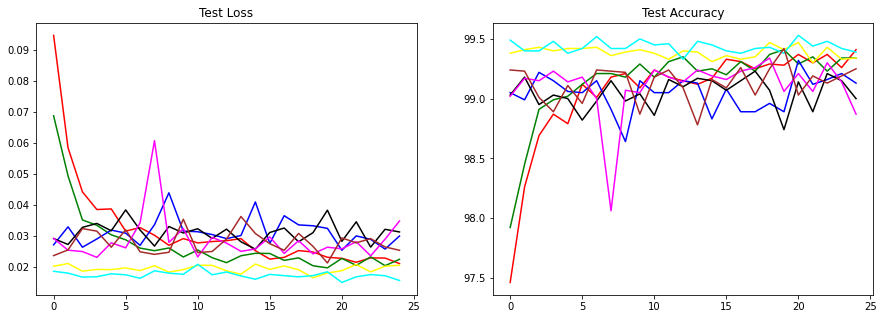

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))
for i in range(1,9):
  if i == 1:
    print("CASE_1: without L1andL2 with BN")

    axs[0].plot(results1[0],color='red')
    axs[0].set_title("Test Loss")
    axs[1].plot(results1[1],color='red')
    axs[1].set_title("Test Accuracy")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')

  elif i == 2:
    print("CASE_2: without L1andL2 with GBN")
    
    axs[0].plot(results2[0],color='green')
    axs[0].set_title("Test Loss")
    axs[1].plot(results2[1],color='green')
    axs[1].set_title("Test Accuracy")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')

  elif i == 3:
    print("CASE_3: with L1 with BN")
    
    axs[0].plot(results3[0],color='blue')
    axs[0].set_title("Test Loss")
    axs[1].plot(results3[1],color='blue')
    axs[1].set_title("Test Accuracy123")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')

  elif i == 4:
    print("CASE_4: with L1 with GBN")
    
    axs[0].plot(results4[0], color='black')
    axs[0].set_title("Test Loss")
    axs[1].plot(results4[1], color='black')
    axs[1].set_title("Test Accuracy")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')

  elif i == 5:
    print("CASE_5: with L2 with BN")
    
    axs[0].plot(results5[0], color='yellow')
    axs[0].set_title("Test Loss")
    axs[1].plot(results5[1], color='yellow')
    axs[1].set_title("Test Accuracy")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')


  elif i == 6:
    print("CASE_6: with L2 with GBN")
    
    axs[0].plot(results6[0], color='cyan')
    axs[0].set_title("Test Loss")
    axs[1].plot(results6[1], color='cyan')
    axs[1].set_title("Test Accuracy")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')


  elif i == 7:
    print("CASE_7: with L1andL2 with BN")
    
    axs[0].plot(results7[0], color='magenta')
    axs[0].set_title("Test Loss")
    axs[1].plot(results7[1], color='magenta')
    axs[1].set_title("Test Accuracy")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')


  elif i == 8:
    print("CASE_8: with L1andL2 with GBN")
    
    axs[0].plot(results8[0], color='brown')
    axs[0].set_title("Test Loss")
    axs[1].plot(results8[1], color='brown')
    axs[1].set_title("Test Accuracy")
    #plt.savefig("/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 6/models/l2-figure.png", bbox_inches='tight')